In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import datetime
import seaborn as sns
os.chdir('/home/emi/unipd/Sartori_CBSD/project/cbsdproject')
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates

In [137]:
#December 2017-February 2018, 
#March 2018-June 2018, 
#July 2018-December 2018, 
#January 2019-May 2019, 
#May 2019-August 2019, 
#September 2019-December 2019

temporal_windows = ['2017-12', '2018-03', '2018-07', '2019-01', '2019-05', '2019-09']
parties={1:16,2:16,3:10,4:12, 5:16}

In [3]:
def return_seaborn_colors(party):
    return sns.color_palette("coolwarm", 20).as_hex()

In [134]:
def plot_frequencies(df, column, filename):
    sns.set(style="darkgrid")
    sns.set_palette("pastel")
    sns.set_context("talk")
    sns.despine()
    sns.countplot(x=column, data=df)
    plt.savefig(filename)
    plt.show()

In [4]:
def get_labels_srt(data, column, substring):
    labels_str= data[column].unique().tolist()
    labels_str.sort()
    labels_str = list(map(str, labels_str))
    labels_str = [substring + ' ' + s  for s in labels_str]
    return labels_str

In [103]:
def create_temporal_topic_frequencies_plot(data, columns, index_temporal_window=None, y_colors=None, filename=None, norm=False):

    df = data.copy()
    
    sns.set()
    sns.set_palette("pastel")
    sns.set_context("talk")
    sns.despine()
    plt.figure(figsize=(16,12))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=20)

    if norm:
        df.loc[:, df.columns != 'created_at'] = (df.loc[:, columns]
                                                 .div(df.loc[:, columns]
                                                 .sum(axis=1), axis=0)
                                                )
    
    plt.stackplot(df['created_at'], 
                  df[columns].T.values, 
                  labels=columns,
                  colors = y_colors)
    
    if (index_temporal_window != None):
        for xc in index_temporal_window:
            plt.axvline(x=xc, color='k', linestyle='--')
        plt.xticks(index_temporal_window)
    plt.legend(bbox_to_anchor=(1.17, 1))
    plt.savefig(f'figures/{filename}.png', bbox_inches='tight')
    plt.show()


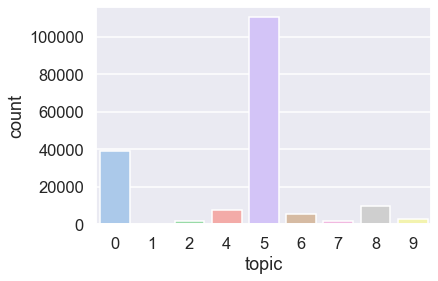

<Figure size 432x288 with 0 Axes>

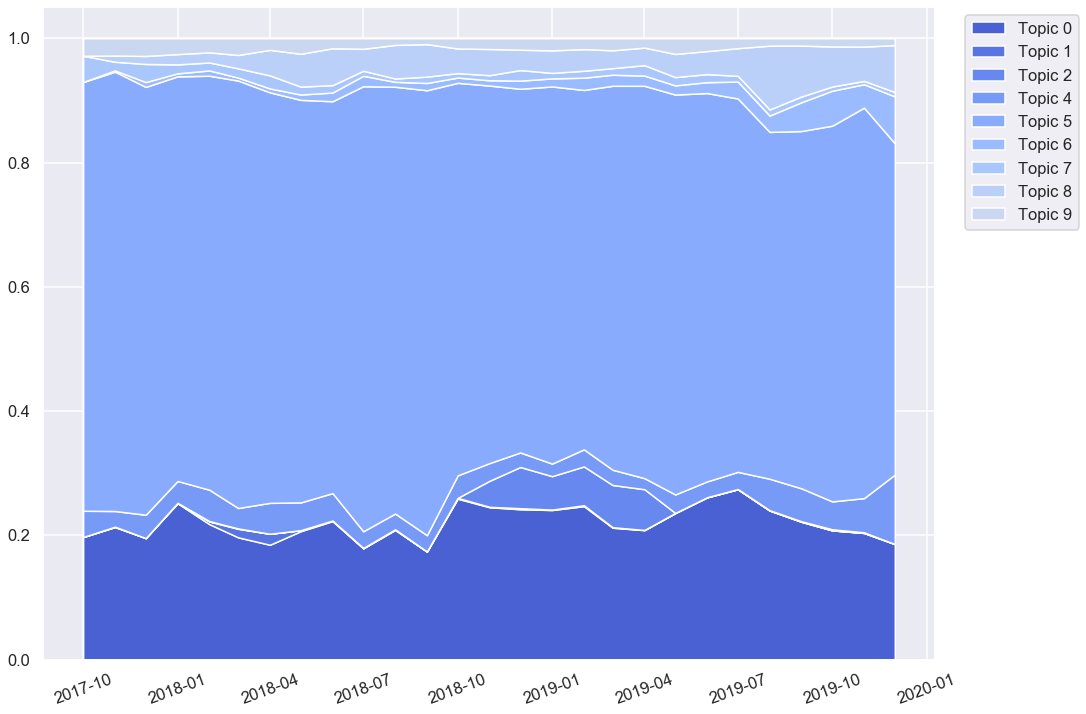

<Figure size 432x288 with 0 Axes>

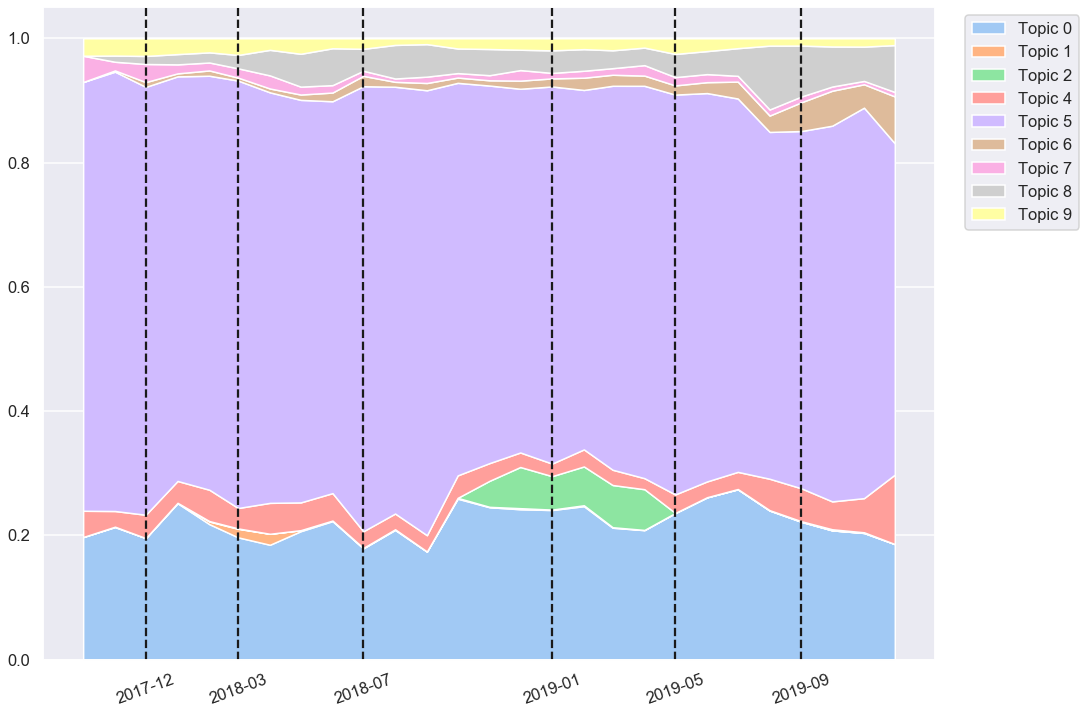

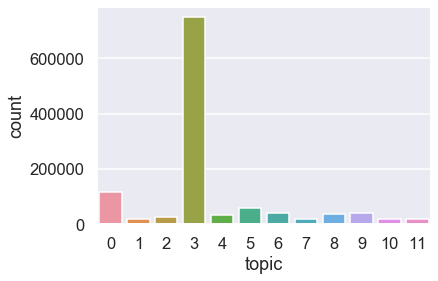

<Figure size 432x288 with 0 Axes>

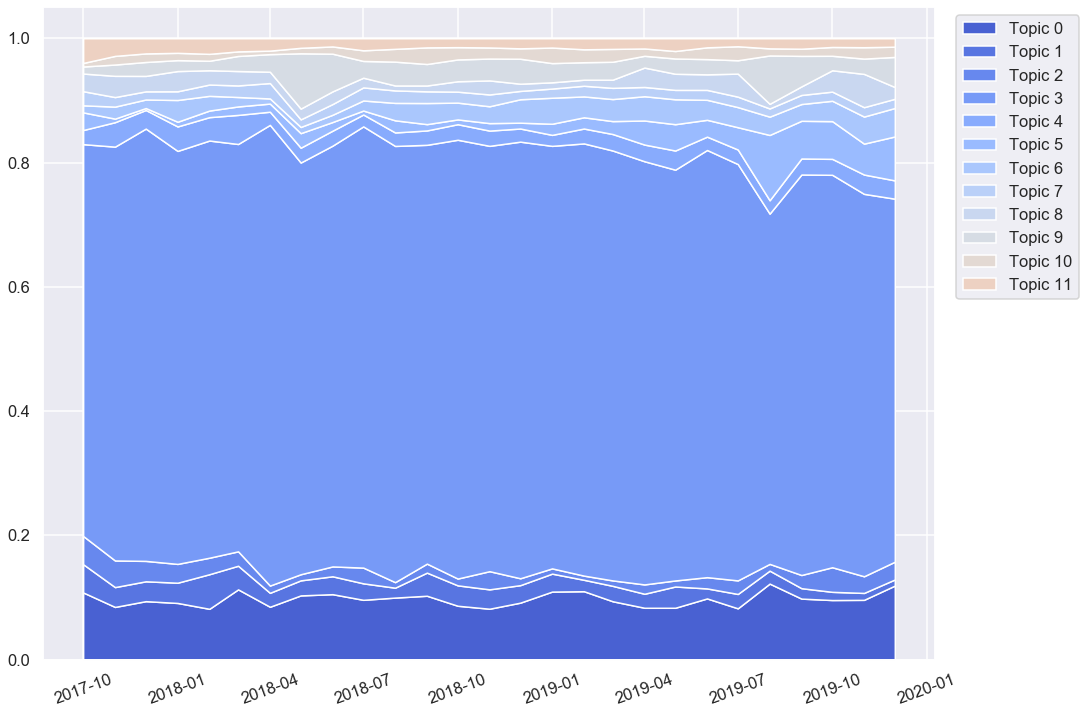

<Figure size 432x288 with 0 Axes>

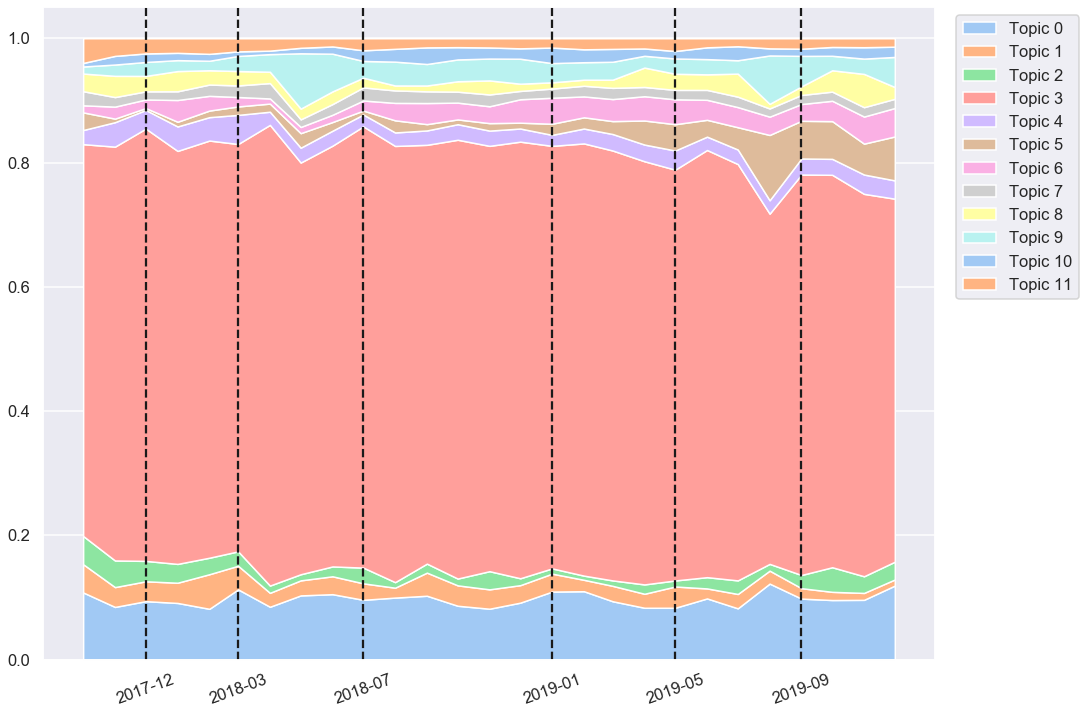

In [139]:
for party in parties.keys():
    file = open(f'models/labels_kmeanstfidf_k{parties[party]}_party{party}.pkl', 'rb')
    labels = pickle.load(file)
    tweets = pd.read_csv(f'data/tweets_party{party}_cleaned.csv')
    tweets['topic'] = pd.Series(labels)
    tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%Y%m%d %H:%M:%S') 
    tweets = tweets[tweets['created_at'] >'2017-10-31']
    
    plot_frequencies(tweets, 'topic', f'figures/topics_frequencies_party{party}_kmeanstfidf_k{parties[party]}.png')
    
    topic_temporality_frequencies = (tweets.groupby([tweets.created_at.dt.year.rename('year'), 
                                                tweets.created_at.dt.month.rename('month'), 
                                                tweets.topic])
                                        .size().reset_index(name='total'))
    topic_temporality_frequencies['created_at'] = pd.to_datetime(
        dict(year=topic_temporality_frequencies['year'], month=topic_temporality_frequencies['month'], day=1))
    topic_temporality_frequencies.sort_values(by=['topic'], inplace=True)
    topic_temporality_frequencies['topic'] = "Topic " + topic_temporality_frequencies['topic'].astype('str')
    df = topic_temporality_frequencies.pivot(index='created_at', columns='topic', values='total')
    df.reset_index(inplace=True)
    df.fillna(0, inplace=True)
    
    labels_str = get_labels_srt(tweets, 'topic', 'Topic')
    colors = return_seaborn_colors(party)
    
    create_temporal_topic_frequencies_plot(df, labels_str, 
                                           y_colors=colors, 
                                           filename=f'topics_temporality_party{party}_kmeanstfidf_k{parties[party]}',
                                          norm=True)
    
    
    create_temporal_topic_frequencies_plot(df, 
                                           labels_str, 
                                           temporal_windows, 
                                           norm=True, 
                                           filename=f'topics_temporality_party{party}_norm_kmeanstfidf_k{parties[party]}')